### aim: 

### date: 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [4]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

import coldic as cd
reload(cd)



<module 'coldic' from '/gpfs/scratch/mep22dku/windEval/plottingCode/coldic.py'>

## dictionary of colors for attribution

In [5]:
m3dict = {
    '1A': {'name': '','color':'darkgray','linestyle' : '-','linewidth' : 1,},
    '1AM2': {'name': '','color':'darkgray','linestyle' : ':','linewidth' : 1,},
    '1AM3': {'name': '','color':'darkgray','linestyle' : '--','linewidth' : 1,},
    '1AEM': {'name': 'SSP 1-2.6 \n HIST. OZONE','color':'darkgray','linestyle' : '-','linewidth' : 2.5,},

    '1B': {'name': '','color':'black','linestyle' : '-','linewidth' : 1,},
    '1BM2': {'name': '','color':'black','linestyle' : ':','linewidth' : 1,},
    '1BM3': {'name': '','color':'black','linestyle' : '--','linewidth' : 1,},
    '1BEM': {'name': 'SSP 3-7.0 \n HIST. OZONE','color':'black','linestyle' : '-','linewidth' : 2.5,},
    
    '2A': {'name': '','color':'mediumaquamarine','linestyle' : '-','linewidth' : 1,},
    '2AM2': {'name': '','color':'mediumaquamarine','linestyle' : ':','linewidth' : 1,},
    '2AM3': {'name': '','color':'mediumaquamarine','linestyle' : '--','linewidth' : 1,},
    '2AEM': {'name': 'SSP 1-2.6 \n NO HOLE','color':'mediumaquamarine','linestyle' : '-','linewidth' : 2.5,},

    '2B': {'name': '','color':'forestgreen','linestyle' : '-','linewidth' : 1,},
    '2BM2': {'name': '','color':'forestgreen','linestyle' : ':','linewidth' : 1,},
    '2BM3': {'name': '','color':'forestgreen','linestyle' : '--','linewidth' : 1,},
    '2BEM': {'name': 'SSP 3-7.0 \n NO HOLE','color':'forestgreen','linestyle' : '-','linewidth' : 2.5,},    
}

## calculate winds, means, extremes

(1826.0, 20453.0)

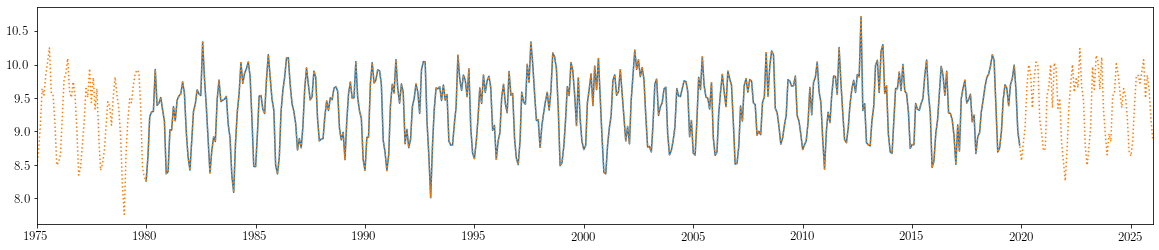

In [6]:
sdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'


scens = ['1A','1B','2A','2B','1AM2','1BM2','2AM2','2BM2','1AEM','2AEM','1BEM','2BEM']
stl = ['1AEM','2AEM','1BEM','2BEM']
scens = ['1B']

ukesm_ts = xr.open_dataset(f'{sdir}/UKESM_40-60S_mean_wspd_ts_1980-2019.nc')
ukesm_ts = ukesm_ts.resample(time_counter='M').mean()
ukesm_ts.time_counter[0]
ukesm_ts.time_counter[479]
times = pd.date_range(f"1980/01/01",f"2020/01/01",freq='MS',closed='left')
ukesm_ts['time_counter'] = times

# ukesm_ts = ukesm_ts.resample(time="1M")
#ukesm_ts = ukesm_ts.indexes['time_counter'].to_datetimeindex()
td = xr.open_dataset(f'{sdir}/scen1B_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
td = td.resample(time_counter='M').mean()
times = pd.date_range(f"1950/01/01",f"2100/01/01",freq='MS',closed='left')
td['time_counter'] = times

plt.figure(figsize = (20,4))
plt.plot(ukesm_ts.time_counter, ukesm_ts.wspd10m)
plt.plot(td.time_counter, td.wspd10m, linestyle = ':')

start_date = pd.to_datetime('1975-01-01')
end_date = pd.to_datetime('2025-12-31')
plt.xlim(start_date, end_date)

## mean and trend calculation

In [8]:
import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p


In [9]:
ex = True

if ex:
    scens = ['1B','2B','1BM2','2BM2','1BEM','2BEM']

    data = np.zeros([3,len(scens)])
    df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])

    for scen in scens:

        td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        df.loc['DJF',scen] = np.nanmean(t)
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        df.loc['JJA',scen] = np.nanmean(t)
        t = td.wspd10m.\
            groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
        df.loc['FY',scen] = np.nanmean(t)

    df.to_csv(f'./plts/UKESM-mn_wspd-1980-1999.csv')

    data = np.zeros([3,len(scens)])
    df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])

    for scen in scens:

        td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        df.loc['DJF',scen] = np.nanmean(t)
        t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        df.loc['JJA',scen] = np.nanmean(t)
        t = td.wspd10m.\
            groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
        df.loc['FY',scen] = np.nanmean(t)

    df.to_csv(f'./plts/UKESM-mn_wspd-1980-2019.csv')
    

In [36]:
scens = ['1B','2B','1BM2','2BM2','1BEM','2BEM']

data = np.zeros([3,len(scens)])
data2 = np.zeros([3,len(scens)])
df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])
df2 = pd.DataFrame(data2, columns=scens, index  = ['FY','DJF','JJA'])

for scen in scens:
    
    td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
    t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
        groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    df.loc['DJF',scen] = lin_slope*10
    print(lin_p)
    if (lin_p < 0.05):
        print('smol')
        df2.loc['DJF',scen] = lin_slope*10
        
    td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
    t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
        groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    print(lin_p)
    df.loc['JJA',scen] = lin_slope*10
    if (lin_p < 0.05):
        print('smol')
        df2.loc['JJA',scen] = lin_slope*10
    
    td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
    t = td.wspd10m.\
        groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    df.loc['FY',scen] = lin_slope*10
    print(lin_p)

    if (lin_p < 0.05):
        print('smol')
        df2.loc['FY',scen] = lin_slope*10
 
df.to_csv(f'./plts/UKESM-trend_wspd-1980-1999.csv')
df2.to_csv(f'./plts/UKESM-trendsig_wspd-1980-1999.csv')

data = np.zeros([3,len(scens)])
data2 = np.zeros([3,len(scens)])
df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])
df2 = pd.DataFrame(data2, columns=scens, index  = ['FY','DJF','JJA'])

for scen in scens:
    
    td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
    t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
        groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    df.loc['DJF',scen] = lin_slope*10
    print(lin_p)
    if (lin_p < 0.05):
        print('smol')
        df2.loc['DJF',scen] = lin_slope*10
        
    td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
    t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
        groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    print(lin_p)
    df.loc['JJA',scen] = lin_slope*10
    if (lin_p < 0.05):
        print('smol')
        df2.loc['JJA',scen] = lin_slope*10
    
    td = xr.open_dataset(f'{sdir}/scen{scen}_UKESM_40-60S_mean_wspd_ts_1950-2099.nc')
    t = td.wspd10m.\
        groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    df.loc['FY',scen] = lin_slope*10
    print(lin_p)

    if (lin_p < 0.05):
        print('smol')
        df2.loc['FY',scen] = lin_slope*10
 
df.to_csv(f'./plts/UKESM-trend_wspd-1980-2019.csv')
df2.to_csv(f'./plts/UKESM-trendsig_wspd-1980-2019.csv')



0.009474856619341691
smol
0.26122302539898157
0.013697687249193593
smol
0.49337255119042756
0.714415040173175
0.5028503279280674
0.0015402227266637033
smol
0.16877065844792816
0.05608392023786492
0.3055665598585471
0.15838103236257808
0.4123053774749518
0.0009535540424512316
smol
0.04182599855014105
smol
0.007856466516903549
smol
0.33436069361345977
0.53571333994644
0.9098689422138462
0.0003795840875219025
smol
0.40028405608164264
0.009951541888338866
smol
0.18452664236162408
0.0571885335965898
0.004517890337644842
smol
0.009685005025982593
smol
0.4643692094016113
0.032359866552681006
smol
0.24863452992566806
0.9573308653259274
0.5479222297491422
3.5744129480259504e-05
smol
0.269415235999423
0.0024247799220667057
smol
0.13226125103865394
0.16903665345034224
0.041504359257207864
smol


## do the same but for ERA5

In [43]:
scens = ['ERA5']
data = np.zeros([3,len(scens)])
data2 = np.zeros([3,len(scens)])
df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])
df2 = pd.DataFrame(data2, columns=scens, index  = ['FY','DJF','JJA'])

for scen in scens:
    
    td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
    t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
        groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    df.loc['DJF',scen] = lin_slope*10
    print(lin_p)
    if (lin_p < 0.05):
        print('smol')
        df2.loc['DJF',scen] = lin_slope*10
        
    td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
    t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
        groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    print(lin_p)
    df.loc['JJA',scen] = lin_slope*10
    if (lin_p < 0.05):
        print('smol')
        df2.loc['JJA',scen] = lin_slope*10
    
    td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
    t = td.wspd10m.\
        groupby('time_counter.year').mean().sel(year = slice(1980, 1999)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    df.loc['FY',scen] = lin_slope*10
    print(lin_p)

    if (lin_p < 0.05):
        print('smol')
        df2.loc['FY',scen] = lin_slope*10
 
df.to_csv(f'./plts/ERA5-trend_wspd-1980-1999.csv')
df2.to_csv(f'./plts/ERA5-trendsig_wspd-1980-1999.csv')

data = np.zeros([3,len(scens)])
data2 = np.zeros([3,len(scens)])
df = pd.DataFrame(data, columns=scens, index  = ['FY','DJF','JJA'])
df2 = pd.DataFrame(data2, columns=scens, index  = ['FY','DJF','JJA'])

for scen in scens:
    
    td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
    t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
        groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    df.loc['DJF',scen] = lin_slope*10
    print(lin_p)
    if (lin_p < 0.05):
        print('smol')
        df2.loc['DJF',scen] = lin_slope*10
        
    td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
    t = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
        groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    print(lin_p)
    df.loc['JJA',scen] = lin_slope*10
    if (lin_p < 0.05):
        print('smol')
        df2.loc['JJA',scen] = lin_slope*10
    
    td = xr.open_dataset(f'{sdir}/ERA5_40-60S_mean_wspd_ts_1980-2019.nc')
    t = td.wspd10m.\
        groupby('time_counter.year').mean().sel(year = slice(1980, 2019)).values 
    mk_slope, mk_p, lin_slope, lin_p = give_trends(t)
    df.loc['FY',scen] = lin_slope*10
    print(lin_p)

    if (lin_p < 0.05):
        print('smol')
        df2.loc['FY',scen] = lin_slope*10
 
df.to_csv(f'./plts/ERA5-trend_wspd-1980-2019.csv')
df2.to_csv(f'./plts/ERA5-trendsig_wspd-1980-2019.csv')


0.03206737316063514
smol
0.3005591377498585
0.0443261698527855
smol
0.0016267566898515136
smol
0.2996731209985746
0.012323658724091562
smol


# calculate trends in the sam, in ukesm (trends in ERA5 and obs calculated already in Fig-SAM)

In [12]:
dss = ['1B','1BM2','1BEM','2B','2BM2','2BEM']

(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen2BEM.nc')
# tdar = [era_ts, ncar_ts, merra_ts, doe_ts,  ukesm_ts]


data = np.zeros([5,6])
sig = np.zeros([5,6])
for i in range(0,6):
    
    prod = dss[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    data[0,i] = lin_slope* 10
    sig[0,i] = lin_p
    
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[1,i] = lin_slope* 10
    sig[1,i] = lin_p    

    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'MAM'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[2,i] = lin_slope* 10
    sig[2,i] = lin_p   
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'JJA'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[3,i] = lin_slope* 10
    sig[3,i] = lin_p   
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'SON'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[4,i] = lin_slope* 10
    sig[4,i] = lin_p   
            
    i = i+1
    
#dss = ['ERA5','NCEP-NCAR','MERRA','JRA3Q','UKESM','obs']
df = pd.DataFrame(data, columns=dss,\
                  index  = ['full year','DJF','MAM','JJA','SON'])
df2 = pd.DataFrame(sig, columns=dss,\
                  index  = ['full year','DJF','MAM','JJA','SON'])

df.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df.to_csv(f'./plts/UKESM-SAM_trend-1980-2019.csv')
df2.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df2.to_csv(f'./plts/UKESM-SAM_trendsig-1980-2019.csv')

dss = ['1B','1BM2','1BEM','2B','2BM2','2BEM']



data = np.zeros([5,6])
sig = np.zeros([5,6])
for i in range(0,6):
    
    prod = dss[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    data[0,i] = lin_slope* 10
    sig[0,i] = lin_p
    
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[1,i] = lin_slope* 10
    sig[1,i] = lin_p    

    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'MAM'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[2,i] = lin_slope* 10
    sig[2,i] = lin_p   
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'JJA'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[3,i] = lin_slope* 10
    sig[3,i] = lin_p   
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen{prod}.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'SON'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[4,i] = lin_slope* 10
    sig[4,i] = lin_p   
            
    i = i+1
    
#dss = ['ERA5','NCEP-NCAR','MERRA','JRA3Q','UKESM','obs']
df = pd.DataFrame(data, columns=dss,\
                  index  = ['full year','DJF','MAM','JJA','SON'])
df2 = pd.DataFrame(sig, columns=dss,\
                  index  = ['full year','DJF','MAM','JJA','SON'])

df.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df.to_csv(f'./plts/UKESM-SAM_trend-1980-1999.csv')
df2.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df2.to_csv(f'./plts/UKESM-SAM_trendsig-1980-1999.csv')



,1B,1BM2,1BEM,2B,2BM2,2BEM
full year,1.457858,2.855372,2.156615,-0.065897,-1.083295,-0.574596
DJF,2.757183,4.438504,3.597843,-1.815983,-1.362509,-1.589246
MAM,2.543888,2.607100,2.575494,0.138478,-0.864564,-0.363043
JJA,0.455488,1.676240,1.065864,1.142457,-2.412664,-0.635104
SON,0.074874,2.699646,1.387260,0.271462,0.306558,0.289010


## figure itself, this is dumb

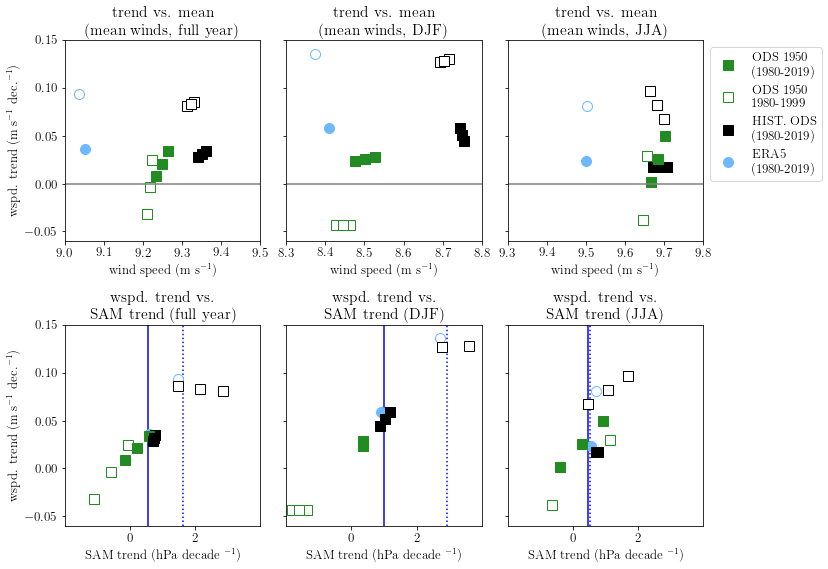

In [13]:
seas = ['FY','DJF','JJA']
    
fact = 1.8
fig, axs = plt.subplots(2,3, figsize=(6.5*fact, 4.5*fact), facecolor='w', edgecolor='k', sharey = True)
axs = axs.ravel()
    
mkz = 's'; ms = 10

mn_2019 = pd.read_csv(f'./plts/UKESM-mn_wspd-1980-2019.csv', index_col=0)
tr_2019 = pd.read_csv(f'./plts/UKESM-trend_wspd-1980-2019.csv', index_col=0)
trs_2019 = pd.read_csv(f'./plts/UKESM-trendsig_wspd-1980-2019.csv', index_col=0)

mn_1999 = pd.read_csv(f'./plts/UKESM-mn_wspd-1980-1999.csv', index_col=0)
tr_1999 = pd.read_csv(f'./plts/UKESM-trend_wspd-1980-1999.csv', index_col=0)
trs_1999 = pd.read_csv(f'./plts/UKESM-trendsig_wspd-1980-1999.csv', index_col=0)

for n in range(0,3):
    
    tseas = seas[n]
    
    scens = ['1B','2B','1BM2','2BM2','1BEM','2BEM']
    #scens = ['1BEM','2BEM']
    
    for s in scens:
        mn = mn_2019.loc[tseas,s]; tr = tr_2019.loc[tseas,s];trs = trs_2019.loc[tseas,s]
        axs[n].plot(mn, tr, color = m3dict[s]['color'], \
                 marker = mkz, markersize = ms, markeredgecolor = m3dict[s]['color'])    
        
        mn = mn_1999.loc[tseas,s];tr = tr_1999.loc[tseas,s];trs = trs_1999.loc[tseas,s]
        axs[n].plot(mn, tr, color = 'w', \
                 marker = mkz, markersize = ms, markeredgecolor = m3dict[s]['color'])   

Emn_2019 = pd.read_csv(f'./plts/ERA5-mn_wspd-1980-2019.csv', index_col=0)
Etr_2019 = pd.read_csv(f'./plts/ERA5-trend_wspd-1980-2019.csv', index_col=0)
Etrs_2019 = pd.read_csv(f'./plts/ERA5-trendsig_wspd-1980-2019.csv', index_col=0)

Emn_1999 = pd.read_csv(f'./plts/ERA5-mn_wspd-1980-1999.csv', index_col=0)
Etr_1999 = pd.read_csv(f'./plts/ERA5-trend_wspd-1980-1999.csv', index_col=0)
Etrs_1999 = pd.read_csv(f'./plts/ERA5-trendsig_wspd-1980-1999.csv', index_col=0)

mkz = 'o'; ms = 10

for n in range(0,3):
    
    tseas = seas[n]
    
    scens = ['1B','2B','1BM2','2BM2','1BEM','2BEM']
    scens = ['ERA5']
    
    for s in scens:
        mn = Emn_2019.loc[tseas,s]; tr = Etr_2019.loc[tseas,s];trs = Etrs_2019.loc[tseas,s]
        axs[n].plot(mn, tr, color = cd.prod['ERA5']['col'], \
                 marker = mkz, markersize = ms, markeredgecolor = cd.prod['ERA5']['col'])    
        
        mn = Emn_1999.loc[tseas,s];tr = Etr_1999.loc[tseas,s];trs = Etrs_1999.loc[tseas,s]
        axs[n].plot(mn, tr, color = 'w', \
                 marker = mkz, markersize = ms, markeredgecolor = cd.prod['ERA5']['col'])     

xmi = [9.0,8.30,9.3]
for i in range(0,3):
    axs[i].set_ylim([-0.06,0.15])
    axs[i].set_xlim([xmi[i], xmi[i]+0.5])
    axs[i].axhline(y=0, color = 'grey')
    
################    
#### - S A M A M A M #####    
############### sam trend

SAM_trend80 = pd.read_csv(f'./plts/SAM_trend-1980-1999.csv', index_col=0)
SAM_sig80 = pd.read_csv(f'./plts/SAM_trendsig-1980-1999.csv', index_col=0)

SAM_trend = pd.read_csv(f'./plts/SAM_trend-1980-2019.csv', index_col=0)
SAM_sig = pd.read_csv(f'./plts/SAM_trendsig-1980-2019.csv', index_col=0)

ind = 0
seas = ['full year','DJF','JJA']
for s in range(0,3):
    
    ts = seas[s]
    if ts == 'full year': ts2 = 'FY'
    else: ts2 = ts
    
    obst = SAM_trend.at[ts, 'obs']
    axs[s+3].axvline(obst, color = 'b')
    obst = SAM_trend80.at[ts, 'obs']
    axs[s+3].axvline(obst, color = 'b', linestyle = ':')
    
    axs[s+3].plot(SAM_trend.at[ts,'ERA5'],Etr_2019.loc[ts2,'ERA5'],color = cd.prod['ERA5']['col'], \
                 marker = mkz, markersize = ms, markeredgecolor = cd.prod['ERA5']['col'])  

    axs[s+3].plot(SAM_trend80.at[ts,'ERA5'],Etr_1999.loc[ts2,'ERA5'],color = 'w', \
                 marker = mkz, markersize = ms, markeredgecolor = cd.prod['ERA5']['col'])  

UKSAM_trend80 = pd.read_csv(f'./plts/UKESM-SAM_trend-1980-1999.csv', index_col=0)
UKSAM_sig80 = pd.read_csv(f'./plts/UKESM-SAM_trendsig-1980-1999.csv', index_col=0)

UKSAM_trend = pd.read_csv(f'./plts/UKESM-SAM_trend-1980-2019.csv', index_col=0)
UKSAM_sig = pd.read_csv(f'./plts/UKESM-SAM_trendsig-1980-2019.csv', index_col=0)

seas = ['full year','DJF','JJA']
mkz = 's'
for s in range(0,3):
    
    ts = seas[s]
    if ts == 'full year': ts2 = 'FY'
    else: ts2 = ts
    
    scens = ['1B','2B','1BM2','2BM2','1BEM','2BEM']
    #scens = ['1BEM','2BEM']
    
    for sc in scens:
        mn = mn_2019.loc[ts2,sc]; tr = tr_2019.loc[ts2,sc];trs = trs_2019.loc[ts2,sc]
    
        axs[s+3].plot(UKSAM_trend.at[ts,sc],tr_2019.loc[ts2,sc],color = m3dict[sc]['color'], \
                     marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'])  

        axs[s+3].plot(UKSAM_trend80.at[ts,sc],tr_1999.loc[ts2,sc],color = 'w', \
                     marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'])  

        
#xmi = [9.15,8.,9.5]
xmi = [9.0,8.30,9.3]
for i in range(0,3):
    axs[i+3].set_ylim([-0.06,0.15])
    #axs[i+3].set_xlim([xmi[i], xmi[i]+0.5])
    # axs[i+3].axhline(y=0, color = 'grey')
    axs[i+3].set_xlim([-1.99,3.99])
    
axs[0].set_ylabel('wspd. trend (m s$^{-1}$ dec.$^{-1})$')
axs[3].set_ylabel('wspd. trend (m s$^{-1}$ dec.$^{-1})$')
tits = ['trend vs. mean \n (mean winds, full year)','trend vs. mean \n (mean winds, DJF)','trend vs. mean \n (mean winds, JJA)']
tits2 = ['wspd. trend vs. \n SAM trend (full year)','wspd. trend vs. \n SAM trend (DJF)','wspd. trend vs. \n SAM trend (JJA)',]
for i in range(0,3):
    axs[i].set_xlabel('wind speed (m s$^{-1}$)')
    axs[i+3].set_xlabel('SAM trend (hPa decade $^{-1}$)')
    axs[i].set_title(tits[i])
    axs[i+3].set_title(tits2[i])
    #axs[1].set_title('DJF')
    
axs[2].plot(1,2, color = m3dict[sc]['color'], marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'], label = 'ODS 1950\n (1980-2019)', linewidth = 0)   
axs[2].plot(1,3, color = 'w', marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'], label = 'ODS 1950\n 1980-1999', linewidth = 0) 
axs[2].plot(1,2, color = 'k', marker = mkz, markersize = ms, markeredgecolor = 'k', label = 'HIST. ODS \n (1980-2019)', linewidth = 0)   
axs[2].plot(1,2, color = cd.prod['ERA5']['col'], marker = 'o', markersize = ms, markeredgecolor = cd.prod['ERA5']['col'], label = 'ERA5 \n (1980-2019)', linewidth = 0)   

axs[2].legend(bbox_to_anchor=[1,1])
    
plt.tight_layout()
plt.savefig(f'./plts/wind-sam-attr-all3members.jpg')

## 1-EM, with significances

0.0257043034976636
0.0149754206930314
0.3231595382839435


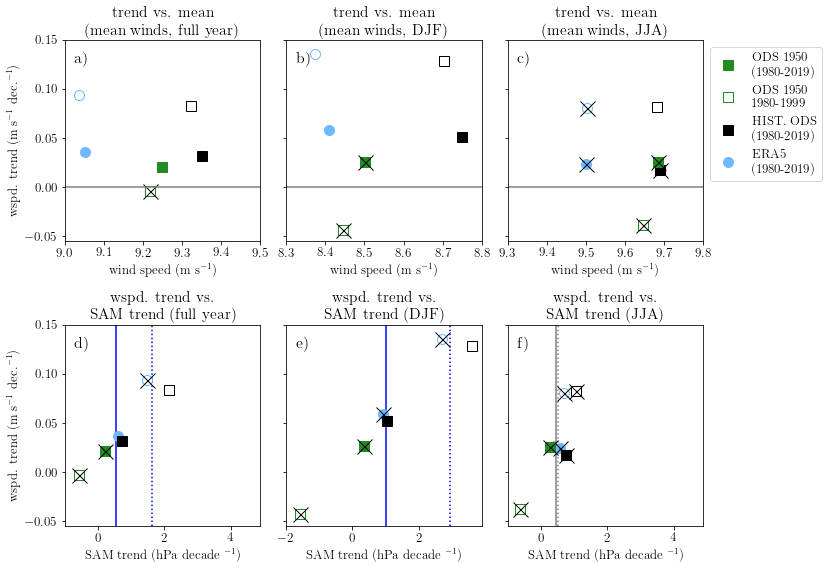

In [63]:
seas = ['FY','DJF','JJA']
    
fact = 1.8
fig, axs = plt.subplots(2,3, figsize=(6.5*fact, 4.5*fact), facecolor='w', edgecolor='k', sharey = True)
axs = axs.ravel()
    
mkz = 's'; ms = 10

mn_2019 = pd.read_csv(f'./plts/UKESM-mn_wspd-1980-2019.csv', index_col=0)
tr_2019 = pd.read_csv(f'./plts/UKESM-trend_wspd-1980-2019.csv', index_col=0)
trs_2019 = pd.read_csv(f'./plts/UKESM-trendsig_wspd-1980-2019.csv', index_col=0)

mn_1999 = pd.read_csv(f'./plts/UKESM-mn_wspd-1980-1999.csv', index_col=0)
tr_1999 = pd.read_csv(f'./plts/UKESM-trend_wspd-1980-1999.csv', index_col=0)
trs_1999 = pd.read_csv(f'./plts/UKESM-trendsig_wspd-1980-1999.csv', index_col=0)

for n in range(0,3):
    
    tseas = seas[n]
    
    scens = ['1B','2B','1BM2','2BM2','1BEM','2BEM']
    scens = ['1BEM','2BEM']
    
    for s in scens:
        mn = mn_2019.loc[tseas,s]; tr = tr_2019.loc[tseas,s];trs = trs_2019.loc[tseas,s]
        axs[n].plot(mn, tr, color = m3dict[s]['color'], marker = mkz, markersize = ms, markeredgecolor = m3dict[s]['color'])    
        if trs == 0:
            axs[n].plot(mn, tr, color = 'k', marker = 'x', markersize = ms+5)                
        
        mn = mn_1999.loc[tseas,s];tr = tr_1999.loc[tseas,s];trs = trs_1999.loc[tseas,s]
        axs[n].plot(mn, tr, color = 'w', marker = mkz, markersize = ms, markeredgecolor = m3dict[s]['color'])   
        if trs == 0:
            axs[n].plot(mn, tr, color = 'k', marker = 'x', markersize = ms+5)       
            
Emn_2019 = pd.read_csv(f'./plts/ERA5-mn_wspd-1980-2019.csv', index_col=0)
Etr_2019 = pd.read_csv(f'./plts/ERA5-trend_wspd-1980-2019.csv', index_col=0)
Etrs_2019 = pd.read_csv(f'./plts/ERA5-trendsig_wspd-1980-2019.csv', index_col=0)

Emn_1999 = pd.read_csv(f'./plts/ERA5-mn_wspd-1980-1999.csv', index_col=0)
Etr_1999 = pd.read_csv(f'./plts/ERA5-trend_wspd-1980-1999.csv', index_col=0)
Etrs_1999 = pd.read_csv(f'./plts/ERA5-trendsig_wspd-1980-1999.csv', index_col=0)

mkz = 'o'; ms = 10

for n in range(0,3):
    
    tseas = seas[n]
    
    scens = ['1B','2B','1BM2','2BM2','1BEM','2BEM']
    scens = ['ERA5']
    
    for s in scens:
        mn = Emn_2019.loc[tseas,s]; tr = Etr_2019.loc[tseas,s];trs = Etrs_2019.loc[tseas,s]
        axs[n].plot(mn, tr, color = cd.prod['ERA5']['col'], \
                 marker = mkz, markersize = ms, markeredgecolor = cd.prod['ERA5']['col'])    
        if trs == 0:
            axs[n].plot(mn, tr, color = 'k',
                     marker = 'x', markersize = ms+5)       
        
        mn = Emn_1999.loc[tseas,s];tr = Etr_1999.loc[tseas,s];trs = Etrs_1999.loc[tseas,s]
        axs[n].plot(mn, tr, color = 'w', \
                 marker = mkz, markersize = ms, markeredgecolor = cd.prod['ERA5']['col'])     
        if trs == 0:
            axs[n].plot(mn, tr, color = 'k',
                     marker = 'x', markersize = ms+5)       

xmi = [9.0,8.30,9.3]
for i in range(0,3):
    axs[i].set_ylim([-0.055,0.15])
    axs[i].set_xlim([xmi[i], xmi[i]+0.5])
    axs[i].axhline(y=0, color = 'grey')
    
    
################    
#### - S A M A M A M #####    
############### sam trend

SAM_trend80 = pd.read_csv(f'./plts/SAM_trend-1980-1999.csv', index_col=0)
SAM_sig80 = pd.read_csv(f'./plts/SAM_trendsig-1980-1999.csv', index_col=0)

SAM_trend = pd.read_csv(f'./plts/SAM_trend-1980-2019.csv', index_col=0)
SAM_sig = pd.read_csv(f'./plts/SAM_trendsig-1980-2019.csv', index_col=0)

ind = 0
seas = ['full year','DJF','JJA']
for s in range(0,3):
    
    ts = seas[s]
    if ts == 'full year': ts2 = 'FY'
    else: ts2 = ts
    
    obst = SAM_trend.at[ts, 'obs']
    sig = SAM_sig.at[ts, 'obs']
    print(sig)
    if sig > 0.05:
        axs[s+3].axvline(obst, color = 'grey')
    else:
        axs[s+3].axvline(obst, color = 'b')
        
    obst = SAM_trend80.at[ts, 'obs']
    sig = SAM_sig80.at[ts, 'obs']
    if sig > 0.05:
        axs[s+3].axvline(obst, color = 'grey', linestyle = ':',)
    else:
        axs[s+3].axvline(obst, color = 'b', linestyle = ':',)
        
    
    axs[s+3].plot(SAM_trend.at[ts,'ERA5'],Etr_2019.loc[ts2,'ERA5'],color = cd.prod['ERA5']['col'], \
                 marker = mkz, markersize = ms, markeredgecolor = cd.prod['ERA5']['col'])  
    
    sts = SAM_sig.at[ts,'ERA5']
    wts = Etr_2019.loc[ts2,'ERA5']
    # print(wts)
    if (sts > 0.05) | (wts > 0.05):
        axs[s+3].plot(SAM_trend.at[ts,'ERA5'],Etr_2019.loc[ts2,'ERA5'],color = 'k', \
                     marker = 'x', markersize = ms+5)  
    
    sts = SAM_sig80.at[ts,'ERA5']
    wts = Etr_1999.loc[ts2,'ERA5']
    axs[s+3].plot(SAM_trend80.at[ts,'ERA5'],Etr_1999.loc[ts2,'ERA5'],color = 'w', \
                 marker = mkz, markersize = ms, markeredgecolor = cd.prod['ERA5']['col']) 
    if (sts > 0.05) | (wts > 0.05):
        axs[s+3].plot(SAM_trend80.at[ts,'ERA5'],Etr_1999.loc[ts2,'ERA5'],color = 'k', \
                     marker = 'x', markersize = ms+5)  

        
UKSAM_trend80 = pd.read_csv(f'./plts/UKESM-SAM_trend-1980-1999.csv', index_col=0)
UKSAM_sig80 = pd.read_csv(f'./plts/UKESM-SAM_trendsig-1980-1999.csv', index_col=0)

UKSAM_trend = pd.read_csv(f'./plts/UKESM-SAM_trend-1980-2019.csv', index_col=0)
UKSAM_sig = pd.read_csv(f'./plts/UKESM-SAM_trendsig-1980-2019.csv', index_col=0)

seas = ['full year','DJF','JJA']
mkz = 's'
for s in range(0,3):
    
    ts = seas[s]
    if ts == 'full year': ts2 = 'FY'
    else: ts2 = ts
    
    scens = ['1B','2B','1BM2','2BM2','1BEM','2BEM']
    scens = ['1BEM','2BEM']
    
    for sc in scens:
        mn = mn_2019.loc[ts2,sc]; tr = tr_2019.loc[ts2,sc];trs = trs_2019.loc[ts2,sc]
    
        axs[s+3].plot(UKSAM_trend.at[ts,sc],tr_2019.loc[ts2,sc],color = m3dict[sc]['color'], \
                     marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'])  
        sts = UKSAM_sig.at[ts,sc]
        if (sts > 0.05) | (trs == 0):
            axs[s+3].plot(UKSAM_trend.at[ts,sc],tr_2019.loc[ts2,sc],color = 'k', \
                         marker = 'x', markersize = ms+5)  

        trs = trs_1999.loc[ts2,sc]
        axs[s+3].plot(UKSAM_trend80.at[ts,sc],tr_1999.loc[ts2,sc],color = 'w', \
                     marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'])  
        sts = UKSAM_sig80.at[ts,sc]
        if (sts > 0.05) | (trs == 0):
            axs[s+3].plot(UKSAM_trend80.at[ts,sc],tr_1999.loc[ts2,sc],color = 'k', \
                         marker = 'x', markersize = ms+5)  

        

xmi = [-1,-2,-1]
for i in range(0,3):

    axs[i+3].set_xlim([xmi[i], xmi[i]+5.9])

    
axs[0].set_ylabel('wspd. trend (m s$^{-1}$ dec.$^{-1})$')
axs[3].set_ylabel('wspd. trend (m s$^{-1}$ dec.$^{-1})$')
tits = ['trend vs. mean \n (mean winds, full year)','trend vs. mean \n (mean winds, DJF)','trend vs. mean \n (mean winds, JJA)']
tits2 = ['wspd. trend vs. \n SAM trend (full year)','wspd. trend vs. \n SAM trend (DJF)','wspd. trend vs. \n SAM trend (JJA)',]
for i in range(0,3):
    axs[i].set_xlabel('wind speed (m s$^{-1}$)')
    axs[i+3].set_xlabel('SAM trend (hPa decade $^{-1}$)')
    axs[i].set_title(tits[i])
    axs[i+3].set_title(tits2[i])
    #axs[1].set_title('DJF')
    
axs[2].plot(1,2, color = m3dict[sc]['color'], marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'], label = 'ODS 1950\n (1980-2019)', linewidth = 0)   
axs[2].plot(1,3, color = 'w', marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'], label = 'ODS 1950\n 1980-1999', linewidth = 0) 
axs[2].plot(1,2, color = 'k', marker = mkz, markersize = ms, markeredgecolor = 'k', label = 'HIST. ODS \n (1980-2019)', linewidth = 0)   
axs[2].plot(1,2, color = cd.prod['ERA5']['col'], marker = 'o', markersize = ms, markeredgecolor = cd.prod['ERA5']['col'], label = 'ERA5 \n (1980-2019)', linewidth = 0)   

axs[2].legend(bbox_to_anchor=[1,1])




axs[0].text(0.05, 0.95, 'a)', transform=axs[0].transAxes,
        fontsize=16, va='top', ha='left')
axs[1].text(0.05, 0.95, 'b)', transform=axs[1].transAxes,
        fontsize=16, va='top', ha='left')
axs[2].text(0.05, 0.95, 'c)', transform=axs[2].transAxes,
        fontsize=16, va='top', ha='left')
axs[3].text(0.05, 0.95, 'd)', transform=axs[3].transAxes,
        fontsize=16, va='top', ha='left')
axs[4].text(0.05, 0.95, 'e)', transform=axs[4].transAxes,
        fontsize=16, va='top', ha='left')
axs[5].text(0.05, 0.95, 'f)', transform=axs[5].transAxes,
        fontsize=16, va='top', ha='left')

plt.tight_layout()
plt.savefig(f'./plts/wind-sam-attr-1M.jpg', dpi = 300)

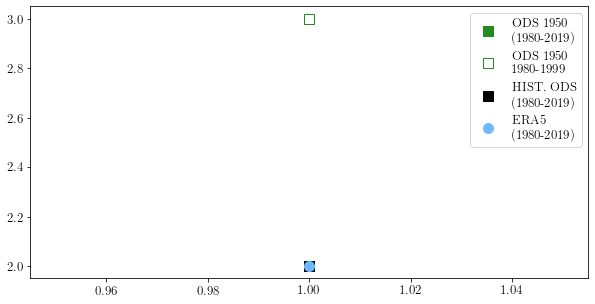

In [15]:
plt.figure(figsize = (10,5))

plt.plot(1,2, color = m3dict[sc]['color'], marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'], label = 'ODS 1950\n (1980-2019)', linewidth = 0)   
plt.plot(1,3, color = 'w', marker = mkz, markersize = ms, markeredgecolor = m3dict[sc]['color'], label = 'ODS 1950\n 1980-1999', linewidth = 0) 
plt.plot(1,2, color = 'k', marker = mkz, markersize = ms, markeredgecolor = 'k', label = 'HIST. ODS \n (1980-2019)', linewidth = 0)   
plt.plot(1,2, color = cd.prod['ERA5']['col'], marker = 'o', markersize = ms, markeredgecolor = cd.prod['ERA5']['col'], label = 'ERA5 \n (1980-2019)', linewidth = 0)   


plt.legend(bbox_to_anchor = [1,1])

## sam index extract


### symlink

In [16]:
import os 

dstdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/symlinked_hrly_UKESM/'
sdirB = '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/'

sdirH = 'member02_cq935/'
sdirF = 'member02_cy233/'

sprefH = 'cq935'
sprefF = 'cy233'
dpref = 'scen2AM2'

ms = ['01', '04','07', '10']

ex = False

if ex:
    
    for y in range(1950,2015):
        for m in ms:

            try:
                src = f'{sdirB}/{sdirH}/{sprefH}_slp_y{y}m{m}.nc'
                dst = f'{dstdir}/{dpref}_slp_y{y}m{m}.nc'
                os.symlink(src,dst)

            except:
                print(f'problem in {sdirH}/{sprefH}_wind_y{y}m{m}.nc')

    for y in range(2015,2101):
        for m in ms:

            try:
                src = f'{sdirB}/{sdirF}/{sprefF}_slp_y{y}m{m}.nc'
                dst = f'{dstdir}/{dpref}_slp_y{y}m{m}.nc'
                os.symlink(src,dst)

            except:
                print(f'problem in {sdirF}/{sprefF}_slp_y{y}m{m}.nc')

    print(f'done {dpref}')

In [17]:
ex = False
scen = 'scen1B'
if ex:

    sam40 = np.zeros(492)
    sam65 = np.zeros(492)
    ind = 0
    for yr in range(1980,2021):
        print(yr)

        if yr < 2015:
            tdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/hist/u-bc370_hist/'
        else:
            tdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/ssp370/u-ce417_ssp370/'


        w1 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m01.nc')
        w4 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m04.nc')
        w7 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m07.nc')
        w10 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m10.nc')

        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m1_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m2_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m3_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m4_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m5_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m6_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m7_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m8_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m9_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m10_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m11_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m12_65f = np.interp(-65, xp, fp)

        ##
        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m1_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m2_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m3_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m4_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m5_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m6_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m7_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m8_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m9_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m10_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m11_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m12_40f = np.interp(-65, xp, fp)

        yr40 = np.array([m1_40f, m2_40f, m3_40f, m4_40f, m5_40f, m6_40f, m7_40f, m8_40f, m9_40f, m10_40f, m11_40f, m12_40f])
        yr65 = np.array([m1_65f, m2_65f, m3_65f, m4_65f, m5_65f, m6_65f, m7_65f, m8_65f, m9_65f, m10_65f, m11_65f, m12_65f])
        sam40[ind:ind+12] = yr40/100
        sam65[ind:ind+12] = yr65/100
        ind = ind+12

    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
        
    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SLP_{scen}.nc')
    
    print(f'UKESM done {scen}')

In [18]:
ex = False
scen = 'scen2B'
if ex:

    sam40 = np.zeros(492)
    sam65 = np.zeros(492)
    ind = 0
    for yr in range(1980,2021):
        print(yr)

        if yr < 2015:
            tdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/hist/u-cj198_hist_1950start1950ozone/'
        else:
            tdir = '/gpfs/data/greenocean/software/resources/MetProcessed/MET_soft/ssp370/u-cj881_ssp370_1950start1950ozone/'


        w1 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m01.nc')
        w4 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m04.nc')
        w7 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m07.nc')
        w10 = xr.open_dataset(f'{tdir}/met_slp_y{yr}m10.nc')

        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m1_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m2_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m3_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m4_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m5_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m6_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m7_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m8_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m9_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m10_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m11_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m12_65f = np.interp(-65, xp, fp)

        ##
        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m1_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m2_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m3_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m4_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m5_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m6_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m7_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m8_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m9_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m10_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m11_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m12_40f = np.interp(-65, xp, fp)

        yr40 = np.array([m1_40f, m2_40f, m3_40f, m4_40f, m5_40f, m6_40f, m7_40f, m8_40f, m9_40f, m10_40f, m11_40f, m12_40f])
        yr65 = np.array([m1_65f, m2_65f, m3_65f, m4_65f, m5_65f, m6_65f, m7_65f, m8_65f, m9_65f, m10_65f, m11_65f, m12_65f])
        sam40[ind:ind+12] = yr40/100
        sam65[ind:ind+12] = yr65/100
        ind = ind+12

    

    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    data.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SLP_{scen}.nc')
    
    print(f'UKESM done {scen}')

In [19]:
time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')

ex = False
scen = 'scen1BM2'
if ex:

    scens = ['scen1BM2','scen2BM2']
    for scen in scens:
        
        sam40 = np.zeros(492)
        sam65 = np.zeros(492)
        ind = 0
        for yr in range(1980,2021):
            print(yr)

            tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/symlinked_hrly_UKESM/'

            w1 = xr.open_dataset(f'{tdir}/{scen}_slp_y{yr}m01.nc')
            w4 = xr.open_dataset(f'{tdir}/{scen}_slp_y{yr}m04.nc')
            w7 = xr.open_dataset(f'{tdir}/{scen}_slp_y{yr}m07.nc')
            w10 = xr.open_dataset(f'{tdir}/{scen}_slp_y{yr}m10.nc')

            t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m1_65f = np.interp(-65, xp, fp)
            t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m2_65f = np.interp(-65, xp, fp)
            t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m3_65f = np.interp(-65, xp, fp)
            t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m4_65f = np.interp(-65, xp, fp)
            t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m5_65f = np.interp(-65, xp, fp)
            t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m6_65f = np.interp(-65, xp, fp)
            t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m7_65f = np.interp(-65, xp, fp)
            t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m8_65f = np.interp(-65, xp, fp)
            t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m9_65f = np.interp(-65, xp, fp)
            t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m10_65f = np.interp(-65, xp, fp)
            t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m11_65f = np.interp(-65, xp, fp)
            t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
            t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
            xp = [-65.625,-64.375]; fp = [t65,t64]
            m12_65f = np.interp(-65, xp, fp)

            ##
            t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m1_40f = np.interp(-65, xp, fp)
            t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m2_40f = np.interp(-65, xp, fp)
            t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m3_40f = np.interp(-65, xp, fp)
            t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m4_40f = np.interp(-65, xp, fp)
            t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m5_40f = np.interp(-65, xp, fp)
            t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m6_40f = np.interp(-65, xp, fp)
            t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m7_40f = np.interp(-65, xp, fp)
            t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m8_40f = np.interp(-65, xp, fp)
            t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m9_40f = np.interp(-65, xp, fp)
            t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m10_40f = np.interp(-65, xp, fp)
            t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m11_40f = np.interp(-65, xp, fp)
            t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
            t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
            xp = [-40.625,-39.375]; fp = [t65,t64]
            m12_40f = np.interp(-65, xp, fp)

            yr40 = np.array([m1_40f, m2_40f, m3_40f, m4_40f, m5_40f, m6_40f, m7_40f, m8_40f, m9_40f, m10_40f, m11_40f, m12_40f])
            yr65 = np.array([m1_65f, m2_65f, m3_65f, m4_65f, m5_65f, m6_65f, m7_65f, m8_65f, m9_65f, m10_65f, m11_65f, m12_65f])
            sam40[ind:ind+12] = yr40/100
            sam65[ind:ind+12] = yr65/100
            ind = ind+12


        data = xr.Dataset(
        {
            "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
            "slp65S": (["time"], [float(i) for i in range(len(time))]), 
        },
        coords={
            "time": time  # time coordinate
        }
        )

        data['slp40S'].values = sam40
        data['slp65S'].values = sam65

        data["slp40S"].attrs["units"] = "hPa"
        data["slp65S"].attrs["units"] = "hPa"

        data.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SLP_{scen}.nc')

        print(f'UKESM done {scen}')

## calculate natural sam index from SLP and get ensemble mean

In [20]:
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','UKESM','ERA5','JRA']
prods = ['scen1BM2','scen2BM2','scen1B','scen2B']
# prods = ['JRA']

ex = False

if ex:
    
    # prods = ['UKESM']

    for prod in prods:
        
        print(prod)
        
        w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SLP_{prod}.nc')



        slp40S_a = w.slp40S - w.slp40S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

        slp65S_a = w.slp65S - w.slp65S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

        # plt.plot(w.time,slp40S_a,linestyle = ':',label = f'{prod}')
        # plt.plot(w.time,slp65S_a,linestyle = '-',label = f'{prod}')   
        plt.plot(w.time,slp40S_a-slp65S_a, label = prod)
        SAM = slp40S_a-slp65S_a
        w['SAM'] = (('time'), SAM)
        w.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_{prod}.nc')
        


In [21]:
prod = 'scen1BM2'
w1 = xr.open_mfdataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_{prod}.nc')
prod = 'scen1B'
w2 = xr.open_mfdataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_{prod}.nc')
w3 = (w2.SAM + w1.SAM)/2
w3.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen1BEM.nc')

prod = 'scen2BM2'
w1 = xr.open_mfdataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_{prod}.nc')
prod = 'scen2B'
w2 = xr.open_mfdataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_{prod}.nc')
w3 = (w2.SAM + w1.SAM)/2
w3.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen2BEM.nc')

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 47292213094528:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


PermissionError: [Errno 13] Permission denied: b'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESM/SAM_scen2BEM.nc'